In [5]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from scipy import optimize
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint 
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from scipy.spatial.distance import cdist
from importlib import reload
import class_flp 
import utils
import time
import random
import pickle
import math
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


### Functions (in Progress)

### Create multiple constrained FLP instances

In [28]:
n_instances = 5
N_range = [int(100+100*n) for n in range(n_instances)]
M_range = [int(2+0.8*m) for m in range(n_instances)]
cov_range = [8+2*p for p in range(n_instances)]
d = 2
scale = 20
seed = 13
N_range, M_range, cov_range

([100, 200, 300, 400, 500], [2, 2, 3, 4, 5], [8, 10, 12, 14, 16])

In [17]:
# annealing parameters
beta0 = 1e-3
betaf = 1e2
beta_grow = 2

# Setting the coefficients for CBF CLF based optimization
alpha_h = 20
alpha_l = 20
p1 = 1
p2 = 10
gamma = 20
u_b = 0.0

# SGF
alpha = 1
kappa = 1

T_f = 10
dt_init = 0.05
dt_max = 0.1
dt_min = 1e-4
Ftol = 0.005 # same for SLSQP and SGF
xtol = 1e-2

# parameters for deterministic annealing based optimization
b1_min = 0.005
b1_max = 200
b1_grow = 5
theta = 5
n_iters = 1000
D_tol = 1e-4

saveFig_opts = {
    'savefig':False
}

### Generate multiple flp instances

In [18]:
flp_instances = []
for N, M, cov in zip(N_range, M_range, cov_range):
    demandLoc, Y0, demand_means, split_pct, rho = utils.generate_testcase(
    N, M, d, unif_split=False, cluster_cov=cov, seed=seed, sq_size=scale, normalizer=False)
    alloc_cost = np.random.uniform(1,1,(N,M))
    mean_alloc_cost = np.mean(alloc_cost)
    C = np.random.uniform(0.4,1,len(split_pct))
    C = (C/np.sum(C) + 0.02) * mean_alloc_cost
    B = np.random.uniform(C.min()*0.1, C.min()*0.3, len(split_pct))
    print(C,B)
    flp = class_flp.FLP(N, M, d, demandLoc, rho, C, B, alloc_cost, P_eps=1e-20, beta_tol=1e-10)
    flp_instances.append(flp)

[0.20812783 0.27485567 0.2557744  0.3412421 ] [0.02953379 0.04404574 0.0610802  0.03242639]


### Solve all the instaces using DA (unconstrained)

In [19]:
DA_sol_instances = []
for i, flp in enumerate(flp_instances):
    print(f'\n------instance:{i}------')
    Y0 = np.random.uniform(-scale, scale,(flp.M,flp.d))
    t0 = time.time()
    F_arr_da, b_arr_da, P_arr_da, Y_arr_da, t_compute_arr_da, cap_arr_da = flp.anneal_DA(Y0, beta0, betaf, beta_grow, n_iters=1000, D_tol=1e-5)
    t1 = time.time()
    sol_instance = {
        'M_name':'DA',
        'n_facilities':flp.M,
        'n_resources':flp.N,
        'resource_locs':flp.resLoc,
        'upper_capacity':flp.C,
        'lower_capacity':flp.B,
        'F_arr':F_arr_da,
        'b_arr':b_arr_da,
        'P_arr':P_arr_da,
        'Y_arr':Y_arr_da,
        't_compute_arr':t_compute_arr_da,
        'cap_arr':cap_arr_da,
        'runtime':t1 - t0
    }
    DA_sol_instances.append(sol_instance)


------instance:0------
tolerance achieved: 	 norm_diff_D=3.275e-06
b:1.000e-03	F:160.8425
tolerance achieved: 	 norm_diff_D=6.746e-06
b:2.000e-03	F:160.8427
tolerance achieved: 	 norm_diff_D=7.748e-06
b:4.000e-03	F:153.7806
tolerance achieved: 	 norm_diff_D=9.850e-06
b:8.000e-03	F:105.0894
tolerance achieved: 	 norm_diff_D=9.655e-06
b:1.600e-02	F:69.4446
tolerance achieved: 	 norm_diff_D=5.610e-06
b:3.200e-02	F:43.3372
tolerance achieved: 	 norm_diff_D=5.790e-06
b:6.400e-02	F:26.6880
tolerance achieved: 	 norm_diff_D=8.104e-06
b:1.280e-01	F:17.9187
tolerance achieved: 	 norm_diff_D=7.821e-06
b:2.560e-01	F:13.4694
tolerance achieved: 	 norm_diff_D=8.307e-06
b:5.120e-01	F:11.0761
tolerance achieved: 	 norm_diff_D=7.316e-06
b:1.024e+00	F:9.8022
tolerance achieved: 	 norm_diff_D=8.515e-06
b:2.048e+00	F:9.1430
tolerance achieved: 	 norm_diff_D=6.277e-06
b:4.096e+00	F:8.8116
tolerance achieved: 	 norm_diff_D=5.008e-06
b:8.192e+00	F:8.6408
tolerance achieved: 	 norm_diff_D=4.154e-06
b:1.638e

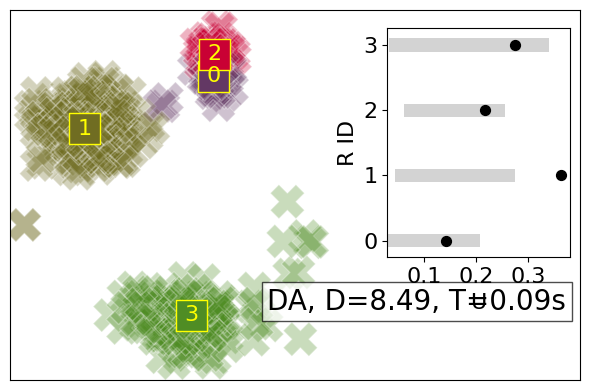

In [15]:

class_flp.plot_flp_sol_instances(
    DA_sol_instances,
    fontSize = 20,
    figSize = (6,4),
    savefig_opts=saveFig_opts,
    plotResTraj = False,
    plotCapacities=True
)

### Solve using our CBF approach

In [16]:
CBF_sol_instances = []
for i, flp in enumerate(flp_instances):
    print(f'\n------instance:{i}------')
    Y0 = np.random.uniform(-scale, scale, (flp.M,flp.d))
    P0 = np.random.uniform(0.0,1,(flp.N, flp.M)) + flp.P_eps
    P0 = P0/P0.sum(axis=1,keepdims=True)
    x0 = utils.YP2x(Y0, P0); print(f'x0\tshape:{x0.shape}')

    t0 = time.time()
    F_arr_cbf, b_arr_cbf, P_arr_cbf, Y_arr_cbf, t_compute_arr_cbf, cap_arr_cbf = flp.anneal_CBF_CLF(
        x0, beta0, betaf, beta_grow, p1, p2, gamma, 
        alpha_h, alpha_l, T_f, dt_init, dt_min, dt_max, 
        Ftol, xtol, allowPrint=True, printOptimizeIters=False)
    t1 = time.time()

    sol_instance = {
        'M_name':'Our',
        'n_facilities':flp.M,
        'n_resources':flp.N,
        'resource_locs':flp.resLoc,
        'upper_capacity':flp.C,
        'lower_capacity':flp.B,
        'F_arr':F_arr_cbf,
        'b_arr':b_arr_cbf,
        'P_arr':P_arr_cbf,
        'Y_arr':Y_arr_cbf,
        't_compute_arr':t_compute_arr_cbf,
        'cap_arr':cap_arr_cbf,
        'runtime':t1-t0
    }
    CBF_sol_instances.append(sol_instance)



------instance:0------
x0	shape:(2008,)


/Users/dhananjaytiwari/Library/Python/3.9/lib/python/site-packages/cvxpy/expressions/expression.py:497: FutureWarning: 
    You didn't specify the order of the flatten expression. The default order
    used in CVXPY is Fortran ('F') order. This default will change to match NumPy's
    default order ('C') in a future version of CVXPY.
    To suppress this warning, please specify the order explicitly.
    
  warnings.warn(flatten_order_warning, FutureWarning)


beta:2.000e-03	F:1.660e+02
beta:4.000e-03	F:1.634e+02
beta:8.000e-03	F:1.555e+02
beta:1.600e-02	F:1.077e+02
beta:3.200e-02	F:7.403e+01
beta:6.400e-02	F:4.853e+01
beta:1.280e-01	F:3.120e+01
beta:2.560e-01	F:2.181e+01
beta:5.120e-01	F:1.679e+01
beta:1.024e+00	F:1.417e+01
beta:2.048e+00	F:1.289e+01
beta:4.096e+00	F:1.215e+01
beta:8.192e+00	F:1.184e+01
beta:1.638e+01	F:1.167e+01
beta:3.277e+01	F:1.159e+01
beta:6.554e+01	F:1.155e+01
beta:1.311e+02	F:1.153e+01


/Users/dhananjaytiwari/Documents/NASA_ULI/CDC2025/CBF_MEP_based_constrained_Resource_Allocation/class_flp.py:960: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


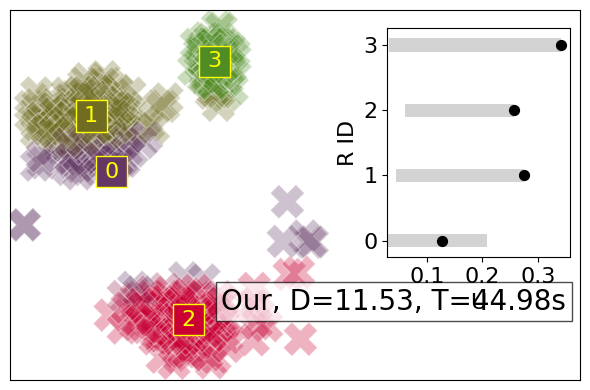

In [21]:
class_flp.plot_flp_sol_instances(
    CBF_sol_instances,
    fontSize = 20,
    figSize = (6,4),
    savefig_opts=saveFig_opts,
    plotResTraj = False,
    plotCapacities=True
)


### Solve using SGF approach

In [22]:
SGF_sol_instances = []
for i, flp in enumerate(flp_instances):
    print(f'\n------instance:{i}------')
    Y0 = np.random.uniform(-scale, scale,(flp.M,flp.d))
    P0 = np.random.uniform(0.0,1,(flp.N, flp.M)) + flp.P_eps
    P0 = P0/P0.sum(axis=1,keepdims=True)
    x0 = utils.YP2x(Y0, P0); print(f'x0\tshape:{x0.shape}')

    t0 = time.time()
    F_arr_sgf, b_arr_sgf, P_arr_sgf, Y_arr_sgf, t_compute_arr_sgf, cap_arr_sgf = flp.anneal_SGF(
        x0, beta0, betaf, beta_grow, alpha, kappa, T_f, dt_init, dt_min, dt_max, Ftol, xtol, allowPrint=True, printOptimizeIters=False)
    t1 = time.time()

    sol_instance = {
        'M_name':'SGF',
        'n_facilities':flp.M,
        'n_resources':flp.N,
        'resource_locs':flp.resLoc,
        'upper_capacity':flp.C,
        'lower_capacity':flp.B,
        'F_arr':F_arr_sgf,
        'b_arr':b_arr_sgf,
        'P_arr':P_arr_sgf,
        'Y_arr':Y_arr_sgf,
        't_compute_arr':t_compute_arr_sgf,
        'cap_arr':cap_arr_sgf,
        'runtime':t1-t0
    }
    SGF_sol_instances.append(sol_instance)




------instance:0------
x0	shape:(2008,)
beta:2.000e-03	F:1.659e+02
beta:4.000e-03	F:1.634e+02
beta:8.000e-03	F:1.621e+02
beta:1.600e-02	F:1.431e+02
beta:3.200e-02	F:7.371e+01
beta:6.400e-02	F:4.884e+01
beta:1.280e-01	F:3.474e+01
beta:2.560e-01	F:2.604e+01
beta:5.120e-01	F:2.209e+01
beta:1.024e+00	F:1.939e+01
beta:2.048e+00	F:1.834e+01
beta:4.096e+00	F:1.782e+01
beta:8.192e+00	F:1.756e+01
beta:1.638e+01	F:1.743e+01
beta:3.277e+01	F:1.737e+01
beta:6.554e+01	F:1.734e+01
beta:1.311e+02	F:1.746e+01


/Users/dhananjaytiwari/Documents/NASA_ULI/CDC2025/CBF_MEP_based_constrained_Resource_Allocation/class_flp.py:960: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


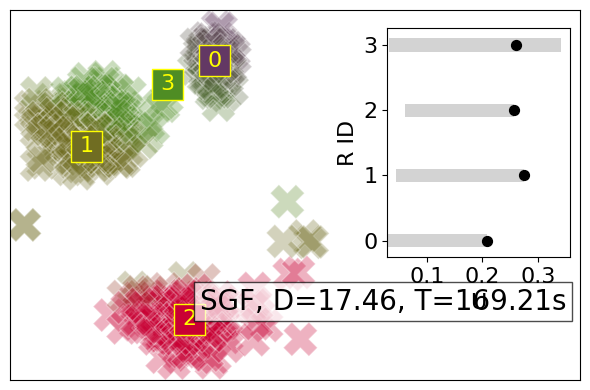

In [24]:
class_flp.plot_flp_sol_instances(
    SGF_sol_instances,
    fontSize = 20,
    figSize = (6,4),
    savefig_opts=saveFig_opts,
    plotResTraj = False,
    plotCapacities=True
)

### Solve using SLSQP

In [81]:
SLSQP_sol_instances = []
for i, flp in enumerate(flp_instances):
    print(f'\n------instance:{i}------')
    Y0 = np.random.uniform(-scale, scale,(flp.M,flp.d))
    P0 = np.random.uniform(0.0,1,(flp.N, flp.M)) + flp.P_eps
    P0 = P0/P0.sum(axis=1,keepdims=True)
    x0 = utils.YP2x(Y0, P0); print(f'x0\tshape:{x0.shape}')

    t0 = time.time()
    F_arr_slsqp, b_arr_slsqp, P_arr_slsqp, Y_arr_slsqp, t_compute_arr_slsqp, cap_arr_slsqp = flp.anneal_SLSQP(
        x0, beta0, betaf, beta_grow, Ftol)
    t1 = time.time()

    sol_instance = {
        'M_name':'SLSQP',
        'n_facilities':flp.M,
        'n_resources':flp.N,
        'resource_locs':flp.resLoc,
        'upper_capacity':flp.C,
        'lower_capacity':flp.B,
        'F_arr':F_arr_slsqp,
        'b_arr':b_arr_slsqp,
        'P_arr':P_arr_slsqp,
        'Y_arr':Y_arr_slsqp,
        't_compute_arr':t_compute_arr_slsqp,
        'cap_arr':cap_arr_slsqp,
        'runtime':t1-t0
    }
    SLSQP_sol_instances.append(sol_instance)




------instance:0------
x0	shape:(456,)
beta:2.000e-03	F:1.262e+02
beta:4.000e-03	F:1.260e+02
beta:8.000e-03	F:1.259e+02
beta:1.600e-02	F:1.258e+02
beta:3.200e-02	F:1.258e+02
beta:6.400e-02	F:1.258e+02
beta:1.280e-01	F:2.637e+01
beta:2.560e-01	F:2.128e+01
beta:5.120e-01	F:1.875e+01
beta:1.024e+00	F:1.723e+01
beta:2.048e+00	F:1.558e+01
beta:4.096e+00	F:1.495e+01
beta:8.192e+00	F:1.460e+01
beta:1.638e+01	F:1.447e+01
beta:3.277e+01	F:1.441e+01
beta:6.554e+01	F:1.438e+01
beta:1.311e+02	F:1.436e+01

------instance:1------
x0	shape:(726,)
beta:2.000e-03	F:1.471e+02
beta:4.000e-03	F:1.367e+02
beta:8.000e-03	F:1.316e+02
beta:1.600e-02	F:1.290e+02
beta:3.200e-02	F:1.277e+02
beta:6.400e-02	F:1.271e+02
beta:1.280e-01	F:4.252e+01
beta:2.560e-01	F:3.486e+01
beta:5.120e-01	F:3.084e+01
beta:1.024e+00	F:2.825e+01
beta:2.048e+00	F:2.714e+01
beta:4.096e+00	F:2.653e+01
beta:8.192e+00	F:2.620e+01
beta:1.638e+01	F:2.606e+01
beta:3.277e+01	F:2.600e+01
beta:6.554e+01	F:2.596e+01
beta:1.311e+02	F:2.595e+01

-

/var/folders/sh/ndxykdmj1q9cwr2kpvkvcbs80000gn/T/ipykernel_2209/3051249569.py:180: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


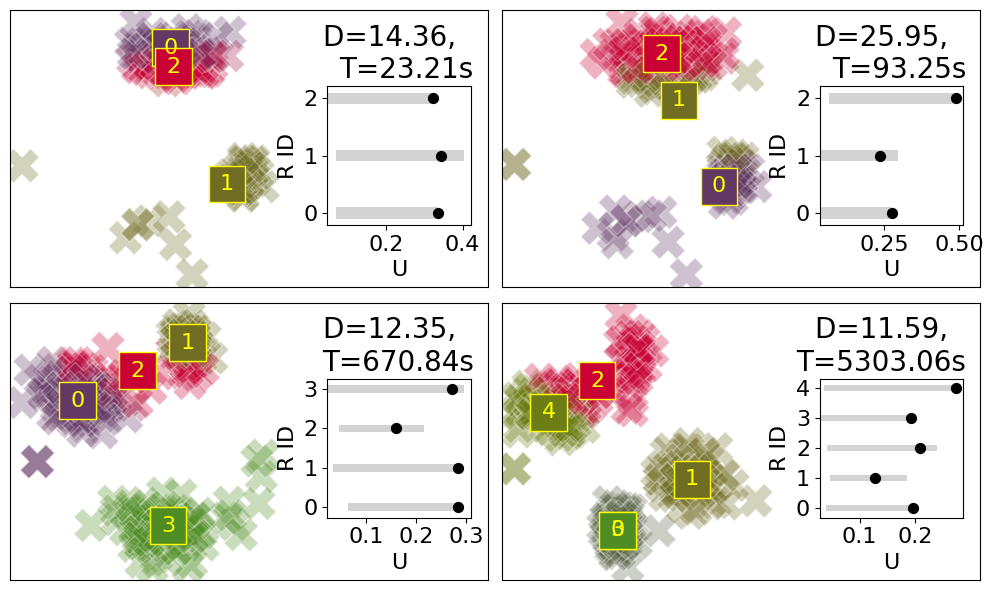

In [82]:
class_flp.plot_flp_sol_instances(
    SLSQP_sol_instances,
    fontSize = 20,
    figSize = (6,4),
    savefig_opts=saveFig_opts,
    plotResTraj = False,
    plotCapacities=True
)

### Solve using penalty based DA (DA-P)

In [83]:
DAC_sol_instances = []
for i, flp in enumerate(flp_instances):
    print(f'\n------instance:{i}------')
    Y0 = np.random.uniform(-scale, scale,(flp.M,flp.d))

    t0 = time.time()
    F_arr_dac, b_arr_dac, P_arr_dac, Y_arr_dac, t_compute_arr_dac, cap_arr_dac = flp.anneal_DA_C(
        Y0, beta0, betaf, beta_grow, b1_min, b1_max, b1_grow, theta, n_iters, D_tol)
    t1 = time.time()

    sol_instance = {
        'M_name':'DAP',
        'n_facilities':flp.M,
        'n_resources':flp.N,
        'resource_locs':flp.resLoc,
        'upper_capacity':flp.C,
        'lower_capacity':flp.B,
        'F_arr':F_arr_dac,
        'b_arr':b_arr_dac,
        'P_arr':P_arr_dac,
        'Y_arr':Y_arr_dac,
        't_compute_arr':t_compute_arr_dac,
        'cap_arr':cap_arr_dac,
        'runtime':t1-t0
    }
    DAC_sol_instances.append(sol_instance)




------instance:0------
cons_violation: [-0.002 -0.07   0.011]
b:2.000e-03	b1_min,b1_max:(1e-05, 0.001)	F:125.7966
cons_violation: [-0.002 -0.069  0.011]
b:4.000e-03	b1_min,b1_max:(2e-05, 0.002)	F:125.7966
cons_violation: [-0.002 -0.069  0.011]
b:8.000e-03	b1_min,b1_max:(4e-05, 0.004)	F:125.7966
cons_violation: [ 0.    -0.064  0.004]
b:1.600e-02	b1_min,b1_max:(8e-05, 0.008)	F:91.3488
cons_violation: [-0.008 -0.069  0.017]
b:3.200e-02	b1_min,b1_max:(0.00016, 0.016)	F:54.9995
cons_violation: [-0.011 -0.067  0.018]
b:6.400e-02	b1_min,b1_max:(0.00032, 0.032)	F:35.0693
cons_violation: [-0.015 -0.063  0.018]
b:1.280e-01	b1_min,b1_max:(0.00064, 0.064)	F:25.0526
cons_violation: [-0.02  -0.058  0.018]
b:2.560e-01	b1_min,b1_max:(0.00128, 0.128)	F:20.0379
cons_violation: [-0.02  -0.058  0.018]
b:5.120e-01	b1_min,b1_max:(0.00256, 0.256)	F:17.0529
cons_violation: [-0.022 -0.056  0.018]
b:1.024e+00	b1_min,b1_max:(0.00512, 0.512)	F:15.2589
cons_violation: [-0.022 -0.056  0.018]
b:2.048e+00	b1_min,b1_

/var/folders/sh/ndxykdmj1q9cwr2kpvkvcbs80000gn/T/ipykernel_2209/3051249569.py:180: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


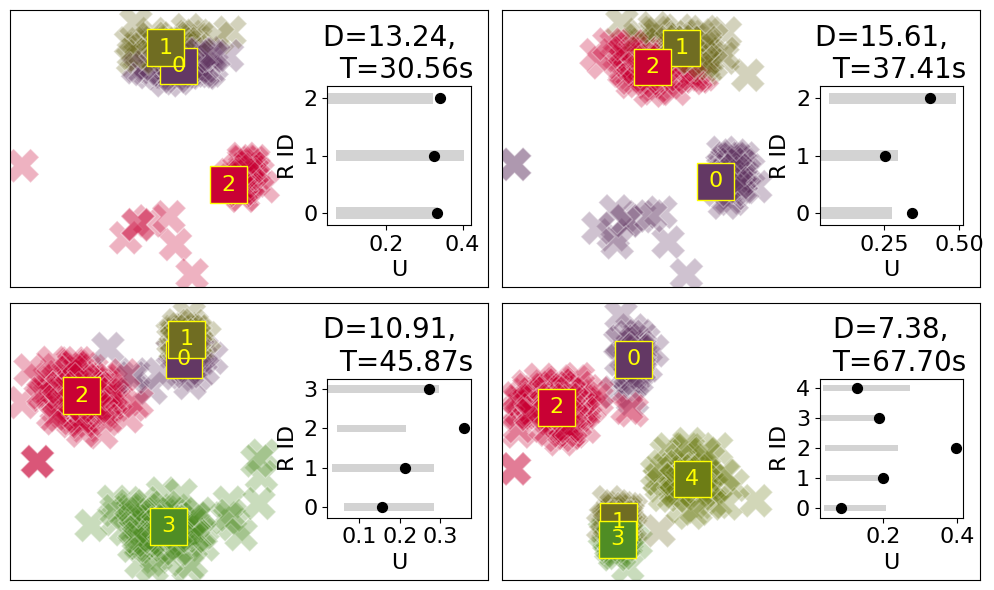

In [84]:
class_flp.plot_flp_sol_instances(
    DAC_sol_instances,
    fontSize = 20,
    figSize = (6,4),
    savefig_opts=saveFig_opts,
    plotResTraj = False,
    plotCapacities=True
)

In [29]:
### Save Data
all_approaches = {
    "DA": DA_sol_instances,
    "CBF": CBF_sol_instances,
    "SGF": SGF_sol_instances,
    "SLSQP": SLSQP_sol_instances,
    "DAC": DAC_sol_instances,
}
Nmin = min(N_range)
Mmin = min(M_range)
Nmax = max(N_range)
Mmax = max(M_range)
filename = f'N_{Nmin}_{Nmax}_M_{Mmin}_{Mmax}_n_instances_{n_instances}_seed_{seed}.pkl'
dir = 'compare_annealing_data/' + filename
print('data file directory:\n'+dir)

with open(dir, 'wb') as f:
    pickle.dump(all_approaches, f)

NameError: name 'SLSQP_sol_instances' is not defined